In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from glob import glob
import os
from PIL import Image
import os.path
from tensorflow.keras.applications.resnet50 import ResNet50
%matplotlib inline
tf.test.is_gpu_available()

True

In [65]:
train_path = '../input/seti-data/primary_small/train'
val_path = '../input/seti-data/primary_small/valid'
test_path = '../input/seti-data/primary_small/test'

In [66]:
categories = glob(train_path + '/*')
categories

['../input/seti-data/primary_small/train/narrowband',
 '../input/seti-data/primary_small/train/noise',
 '../input/seti-data/primary_small/train/brightpixel',
 '../input/seti-data/primary_small/train/squarepulsednarrowband',
 '../input/seti-data/primary_small/train/narrowbanddrd',
 '../input/seti-data/primary_small/train/squiggle',
 '../input/seti-data/primary_small/train/squigglesquarepulsednarrowband']

In [67]:
len(categories)

7

In [68]:
l = os.walk(train_path)
cat = next(os.walk(train_path))[1]
cat

['narrowband',
 'noise',
 'brightpixel',
 'squarepulsednarrowband',
 'narrowbanddrd',
 'squiggle',
 'squigglesquarepulsednarrowband']

../input/seti-data/primary_small/train/narrowband/348_narrowband.png


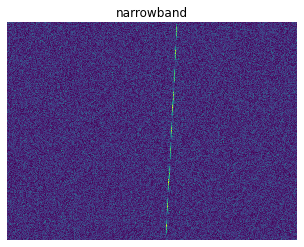

../input/seti-data/primary_small/train/noise/4042_noise.png


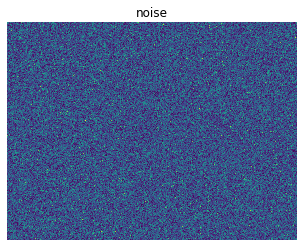

../input/seti-data/primary_small/train/brightpixel/2817_brightpixel.png


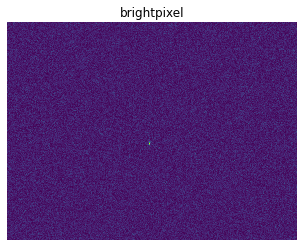

../input/seti-data/primary_small/train/squarepulsednarrowband/6631_squarepulsednarrowband.png


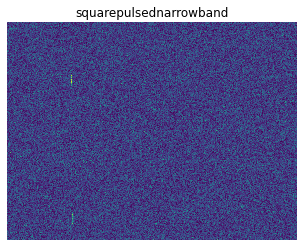

../input/seti-data/primary_small/train/narrowbanddrd/2247_narrowbanddrd.png


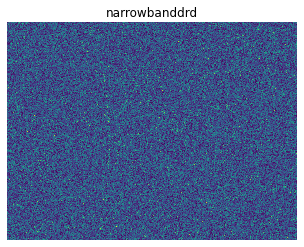

../input/seti-data/primary_small/train/squiggle/6025_squiggle.png


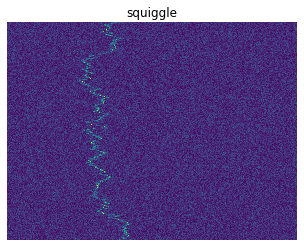

../input/seti-data/primary_small/train/squigglesquarepulsednarrowband/3074_squigglesquarepulsednarrowband.png


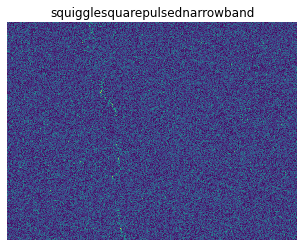

In [69]:
count = 0
count_dict = {}
for i in categories:
    imgs = glob(i + '/*.png')
    for j in imgs[0:1]:
        print(j)
        filename = os.path.join(j)
        img = Image.open(filename)
        plt.imshow(img,interpolation = 'nearest')
        plt.axis('off')
        plt.title(cat[count])
        plt.show()
        count_dict[cat[count]] = len(imgs)
        count = count + 1

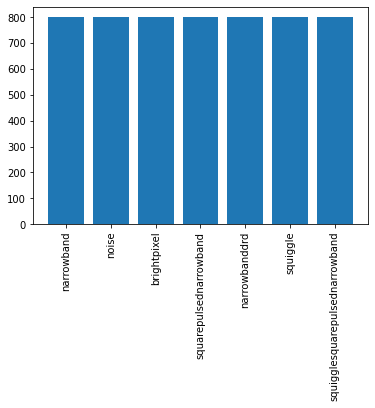

In [70]:
plt.bar(range(len(count_dict)),list(count_dict.values()))
plt.xticks(range(len(count_dict)),list(count_dict.keys()),rotation = 90)
plt.show()

In [71]:
# Hyperparameters
batch_size = 32
input_shape = 224
learning_rate = 1e-4
epoch = 45

In [72]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, 
                                                            zoom_range = 0.1, 
                                                            horizontal_flip = True,
                                                            vertical_flip = True)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
train_ds = train_gen.flow_from_directory(train_path, 
                                         batch_size = batch_size, 
                                         target_size = (input_shape,input_shape), 
                                         class_mode = 'categorical',
                                         shuffle = True)
val_ds = val_gen.flow_from_directory(val_path, 
                                     batch_size = batch_size, 
                                     target_size = (input_shape,input_shape), 
                                     class_mode = 'categorical',
                                     shuffle = True)

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [73]:
resnet = ResNet50(input_shape = [input_shape,input_shape] + [3],weights = 'imagenet', include_top = False)
resnet.trainable = True

In [74]:
x = tf.keras.layers.Flatten()(resnet.output)
dropout0 = tf.keras.layers.Dropout(0.4)
x = tf.keras.layers.Dense(1024,activation = 'relu')(x)
dropout1 = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512,activation = 'relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256,activation = 'relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(len(categories),activation = 'softmax')(dropout3)
model = tf.keras.Model(inputs = resnet.input,outputs = output_layer)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [75]:
optimiser = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer = optimiser,loss = loss_fn,metrics = ['accuracy'])

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            min_delta = 0.005,
                                            patience = 5,
                                            verbose = 1)
history = model.fit(train_ds,
                    batch_size = batch_size,
                    epochs = epoch,
                    callbacks = [callback],
                    validation_data = val_ds,
                    steps_per_epoch = len(train_ds),
                    validation_steps = len(val_ds),
                    validation_batch_size = batch_size)

Epoch 1/45
175/175 [==============================] - 127s 698ms/step - loss: 3.0519 - accuracy: 0.2419 - val_loss: 11.8314 - val_accuracy: 0.1429
Epoch 2/45
175/175 [==============================] - 121s 689ms/step - loss: 1.5293 - accuracy: 0.4299 - val_loss: 30.8807 - val_accuracy: 0.1429
Epoch 3/45
175/175 [==============================] - 121s 689ms/step - loss: 1.1651 - accuracy: 0.5830 - val_loss: 36.9743 - val_accuracy: 0.1429
Epoch 4/45
175/175 [==============================] - 121s 689ms/step - loss: 1.0093 - accuracy: 0.6396 - val_loss: 8.8605 - val_accuracy: 0.1429
Epoch 5/45
175/175 [==============================] - 121s 691ms/step - loss: 0.9320 - accuracy: 0.6661 - val_loss: 22.2037 - val_accuracy: 0.1429
Epoch 6/45
175/175 [==============================] - 121s 689ms/step - loss: 0.8226 - accuracy: 0.7179 - val_loss: 12.1893 - val_accuracy: 0.1443
Epoch 7/45
175/175 [==============================] - 120s 686ms/step - loss: 0.8391 - accuracy: 0.7087 - val_loss: 1.3

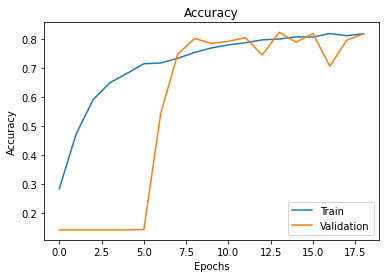

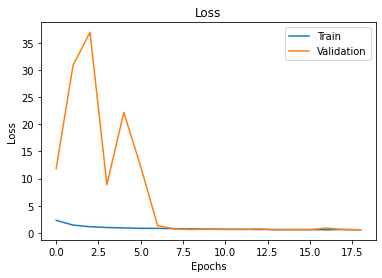

In [77]:
obj = history.history
plt.plot(obj['accuracy'])
plt.plot(obj['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc = 'lower right')
plt.show()

plt.plot(obj['loss'])
plt.plot(obj['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc = 'upper right')
plt.show()

In [78]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_ds = test_gen.flow_from_directory(test_path,
                                       batch_size = 1,
                                       target_size = (input_shape,input_shape), 
                                       class_mode = 'categorical',
                                       shuffle = True)

Found 700 images belonging to 7 classes.


In [79]:
model.evaluate(test_ds,batch_size = 1)

700/700 [==============================] - 10s 15ms/step - loss: 0.5583 - accuracy: 0.8143


[0.5583458542823792, 0.8142856955528259]